In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime

Скачайте датасет и проведите RFM анализ. В каждом подсегменте поделите пользователей на 4 класса. Отсчитывайте количество дней, прошедших с момента последней покупки, с максимальной даты покупки в датасете.

- Какое максимальное кол-во покупок было совершено одним пользователем?
- Какая верхняя граница у суммы покупок у пользователей с классом 4 в подсегменте М? (Другими словами: пользователи, у которых сумма покупок от 0 до Х попадают в 4 класс в подсегменте М)
- Какая нижняя граница у количества покупок у пользователей с классом 1 в подсегменте F?
- Какая верхняя граница у количества покупок у пользователей с классом 2 в подсегменте R?
- Сколько пользователей попало в сегмент 111?
- Сколько пользователей попало в сегмент 311?
- В каком RFM-сегменте самое большое кол-во пользователей?
- В каком RFM-сегменте самое маленькое кол-во пользователей?
- Какое количество пользователей попало в самый малочисленный сегмент?

In [10]:
df = pd.read_csv('RFM_ht_data.csv', dtype={'CustomerCode': str}, parse_dates=['InvoiceDate'])
df

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00
...,...,...,...,...
332725,S0081810310459,14092500,2020-09-30,3801.87
332726,S0081810310461,99065678,2020-09-30,5769.88
332727,S0081810310462,19029918,2020-09-30,736.88
332728,S0081810310463,13020033,2020-09-30,1475.20


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332730 entries, 0 to 332729
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     332730 non-null  object        
 1   CustomerCode  332730 non-null  object        
 2   InvoiceDate   332730 non-null  datetime64[ns]
 3   Amount        332730 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 10.2+ MB


Какое максимальное кол-во покупок было совершено одним пользователем?

In [29]:
df.CustomerCode.value_counts().sort_values().max()

204

In [13]:
df.query(' CustomerCode == 19057820').CustomerCode.value_counts()

Series([], Name: CustomerCode, dtype: int64)

Какая верхняя граница у суммы покупок у пользователей с классом 4 в подсегменте М? (Другими словами: пользователи, у которых сумма покупок от 0 до Х попадают в 4 класс в подсегменте М)

In [31]:
# Matplotlib forms basis for visualization in Python
import matplotlib.pyplot as plt

# We will use the Seaborn library
import seaborn as sns
sns.set()

# Graphics in SVG format are more sharp and legible
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg'")

# Increase the default plot size and set the color scheme
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['image.cmap'] = 'viridis'

Считаем RFM показатели

In [30]:
# дата последней покупки
last_date = df.InvoiceDate.max()
last_date

In [17]:
rfmTable = df.groupby('CustomerCode', as_index=False).agg({'InvoiceDate': lambda x: (last_date - x.max()).days, # Recency Количество дней с последнего заказа
                                        'InvoiceNo': lambda x: len(x),      # Frequency Количество заказов
                                        'Amount': lambda x: x.sum()}) # Monetary Value Общая сумма по всем заказам

In [18]:
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'Amount': 'monetary_value'}, inplace=True)

In [19]:
rfmTable

,CustomerCode,recency,frequency,monetary_value
0,02213019,19,1,1609.20
1,02213042,22,3,9685.48
2,02213071,29,1,415.00
3,02213088,23,1,305.00
4,02213092,25,1,1412.88
...,...,...,...,...
123728,99099927,10,1,961.10
123729,99099936,0,1,1521.78
123730,99099959,8,2,1444.56
123731,99099963,19,1,3018.91


Сегментируем по основным квантилям

In [20]:
quantiles = rfmTable.quantile(q=[.25, .5, .75])
quantiles

,recency,frequency,monetary_value
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


In [21]:
rfmSegmentation = rfmTable

определяем функции для присваивания сегмента

In [22]:
def RClass(value, parameter_name, quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FMClass(value, parameter_name, quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1

сегментируем клиентов

In [32]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency', quantiles))
rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency', quantiles))
rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value', quantiles))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) \
                            + rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str)
rfmSegmentation

,CustomerCode,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
0,02213019,19,1,1609.20,4,4,3,443
1,02213042,22,3,9685.48,4,2,1,421
2,02213071,29,1,415.00,4,4,4,444
3,02213088,23,1,305.00,4,4,4,444
4,02213092,25,1,1412.88,4,4,3,443
...,...,...,...,...,...,...,...,...
123728,99099927,10,1,961.10,3,4,3,343
123729,99099936,0,1,1521.78,1,4,3,143
123730,99099959,8,2,1444.56,2,3,3,233
123731,99099963,19,1,3018.91,4,4,2,442


Какая верхняя граница у суммы покупок у пользователей с классом 4 в подсегменте М? (Другими словами: пользователи, у которых сумма покупок от 0 до Х попадают в 4 класс в подсегменте М)

In [39]:
rfmSegmentation.query("M_Quartile == 4").monetary_value.max()

1

Какая нижняя граница у количества покупок у пользователей с классом 1 в подсегменте F?

In [40]:
rfmSegmentation.query("F_Quartile == 1").frequency.min()

4

Какое максимальное количество дней может пройти с момента последней покупки для того, чтобы пользователь попал в класс 2 в подсегменте R?

In [43]:
rfmSegmentation.query("R_Quartile == 2").recency.max()

8

Сколько пользователей попало в сегмент  
-111?  
-311?  
-В каком RFM-сегменте самое большое кол-во пользователей?

In [59]:
print("пользователей в сегменте 111:", rfmSegmentation.query("RFMClass == '111'")['CustomerCode'].count())
print("пользователей в сегменте 311:", rfmSegmentation.query("RFMClass == '311'")['CustomerCode'].count())
print("больше всего пользователей в:", rfmSegmentation.RFMClass.value_counts().idxmax(), "сегменте")

пользователей в сегменте 111: 9705
пользователей в сегменте 311: 1609
больше всего пользователей в: 444 сегменте


In [26]:
pd.crosstab(index = rfmSegmentation.R_Quartile, columns = rfmSegmentation.F_Quartile)

F_Quartile,1,2,3,4
R_Quartile,,,,
1,14433,4671,5795,6074
2,9634,5889,8633,10399
3,3091,3748,7734,13263
4,542,1311,5415,23101


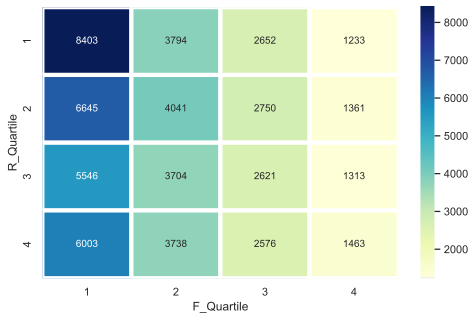

In [27]:
rfm_table2 = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary_value', 
                        aggfunc=np.mean).applymap(int)

sns.heatmap(rfm_table2, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10})
plt.show()